# Heston model: vanilla and forward prices

In [50]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import bisect
import cmath
import matplotlib.pyplot as plt
from math import isnan
from scipy.stats import norm

# The Heston model

Recall the following option price formula for a European Call option with maturity $T$ and strike $K$:
\begin{align*}
\mathbb{E}\left(S_T - \mathrm{e}^{k}\right)_+
 & = S_0\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi-\mathrm{i})}{\mathrm{i}\xi\Phi_T(-\mathrm{i})}
 \mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right)
-K\mathrm{e}^{-rT}\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi)}{\mathrm{i}\xi}\mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right)\\
 & =: S_0 \Pi_1 - K\mathrm{e}^{-rT}\Pi_2,
\end{align*}
where $\Phi_T(\xi):=\mathbb{E}\left(S_T^{\mathrm{i}\xi}\right)$
is the characteristic function of the log-stock price at time $T$.


We shall use here the slightly-rewritten expression:
\begin{align*}
\mathbb{E}\left(S_T - K\right)_+
 & = S_0\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi-\mathrm{i})}{\mathrm{i}\xi}
 \mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right)
-K\mathrm{e}^{-rT}\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi)}{\mathrm{i}\xi}\mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right)\\
 & =: S_0 \Pi_1 - K\mathrm{e}^{-rT}\Pi_2,
\end{align*}
where $K:=S_0\mathrm{e}^{k}$.
    


The characteristic function has the following form:
$\Phi_T(\xi) = \exp\Big(C_T(\xi) + D_T(\xi)V_0 + \mathrm{i}\xi \log(S_0)\Big)$, where
\begin{align*}
C_T(\xi) & : = \mathrm{i}r\xi T + \frac{\kappa\theta}{\sigma^2}\left\{\left(\kappa-\mathrm{i}\rho\sigma\xi-d_T(\xi)\right)T
- 2\log\left(\frac{1-\gamma_T(\xi)\mathrm{e}^{-d_T(\xi)T}}{1-\gamma_T(\xi)}\right)\right\},\\
D_T(\xi) & : = \frac{\kappa - \mathrm{i}\rho\sigma\xi - d_T(\xi)}{\sigma^2}
\left(\frac{1-\mathrm{e}^{-d_T(\xi)T}}{1-\gamma_T(\xi)\mathrm{e}^{-d_T(\xi)T}}\right),\\
\gamma_T(\xi) & := \frac{\kappa - \mathrm{i}\rho\sigma\xi - d_T(\xi)}{\kappa - \mathrm{i}\rho\sigma\xi + d_T(\xi)},
\qquad 
d_T(\xi) := \sqrt{(\kappa-\mathrm{i}\rho\sigma\xi)^2 + \sigma^2(\mathrm{i}\xi+\xi^2)}.
\end{align*}


## Black-Scholes formulae

In [51]:
def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

# Pricing Vanilla options

In [52]:
def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)

### Example

In [53]:
v0,kappa,theta,sigma,rho = 0.1, 1., 0.25, 0.3, -0.2
hestonParams = kappa, theta, sigma, rho, v0 
r, s0, K, T = 0., 1., 1., 3.

In [54]:
print("Call option price: ", heston_EuropeanCall(hestonParams,r,T,s0,K))
print("Implied volatility: ", heston_Impliedvol(hestonParams,r,T,s0,K))

Call option price:  0.29762404877689647
Implied volatility:  0.4412285751258531


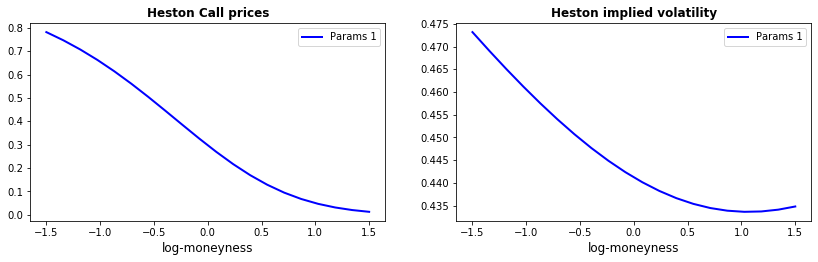

In [55]:
xx = np.linspace(-1.5, 1.5, 20)
calls = [heston_EuropeanCall(hestonParams,r,T,s0,s0*np.exp(x)) for x in xx]
ivs = [heston_Impliedvol(hestonParams,r,T,s0,s0*np.exp(x)) for x in xx]

fig = plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.plot(xx, calls, 'b-', label="Params 1", linewidth=2)
plt.title("Heston Call prices", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.legend(loc=1)
plt.subplot(2, 2, 2)
plt.plot(xx, ivs, 'b-', label="Params 1", linewidth=2)
plt.title("Heston implied volatility", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.legend(loc=1)
plt.show()

# Forward-start pricing

We are now interested in forward-start Call otions, the value of which is given, at inception, by
$$
\mathbb{E}\left[\left(\frac{S_{t+\tau}}{S_t} - K\right)_+\right],
$$
for some forward-starting date $t\geq 0$ and some remaining maturity $\tau\geq 0$.
Obviously this coincides with the vanilla option whenever $t=0$. 
The functions below are normalised with $S_0=1$.

## Forward characteristic function

In [56]:
def LittleB(t, hestonParams):
    return ((xi*xi)/(4.0*kappa))*(1. - np.exp(-kappa*t))
    
def d(u, hestonParams):
    kappa, theta, xi, rho, v0 = hestonParams
    return cmath.sqrt(((kappa - rho*xi*u)*(kappa - rho*xi*u)) + u*(1. - u)*xi*xi)

def LittleGamma(u, hestonParams):
    kappa, theta, xi, rho, v0 = hestonParams
    dd = d(u, hestonParams)
    return (kappa - rho*xi*u - dd)/(kappa-rho*xi*u + dd)

def BigA(u, tau, hestonParams):
    kappa, theta, xi, rho, v0 = hestonParams
    ddd = d(u,hestonParams)
    g = LittleGamma(u,hestonParams)
    LL = cmath.log((1.0-g*cmath.e**(-ddd*tau))/(1.-g))
    return ((kappa*theta)/(xi*xi))*((kappa-rho*xi*u-ddd)*tau-2.*LL)

def BigB(u, tau, hestonParams):
    kappa, theta, xi, rho, v0 = hestonParams
    ddd = d(u,hestonParams)
    ee = cmath.e**(-ddd*tau)
    return (1./(xi*xi))*(kappa-rho*xi*u-ddd)*((1.-ee)/(1.-LittleGamma(u, hestonParams)*ee))

def cfHestonFwd(u, t, tau, hestonParams):
    kappa, theta, xi, rho, v0 = hestonParams
    BBB = BigB(u, tau, hestonParams)
    BBb = LittleB(t, hestonParams)
    return cmath.e**(BigA(u, tau, hestonParams)+(BBB/(1.-2.*BBb*BBB))*(v0*(np.exp(-kappa*t)))-((2.*kappa*theta)/(xi*xi))*cmath.log(1.-2.*BBb*BBB))

def intPhi(w, alpha, k, t, tau, hestonParams):
    return (cmath.e**(-k*(alpha+1j*w))*cfHestonFwd(alpha+1j*w,t,tau,hestonParams)/((alpha+1j*w)*(1.0-alpha-1j*w))).real

In [57]:
def hestonForwardCallPrice(K, t, tau, hestonParams, precision=20.):
    alpha = 0.5
    pp = cfHestonFwd(1., t, tau, hestonParams).real
    return (pp-K/(2.*np.pi)*quad(lambda w: intPhi(w, alpha,np.log(K),t,tau,hestonParams),-precision,precision)[0]).real

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)

def hestonImpliedVol_Fwd(K, t, tau,hestonParams, precision=200.):
    myPrice = hestonForwardCallPrice(K, t, tau, hestonParams, precision)
    def smileMin(vol, *args):
        K, s0, tau, r, price = args
        return price - BlackScholes(True, 1., K, tau, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, 1., tau, r, myPrice), xtol=1e-20, rtol=1e-15, full_output=False, disp=True)


# Comparison

In [58]:
K, v0, kappa, theta, xi, rho = 0.7, 0.05, 2.1, 0.03, 0.1, -0.2
t, tau = 1., 1.
hestonParams = kappa, theta, xi, rho, v0

In [59]:
print("Forward Call price: ", hestonForwardCallPrice(K,t,tau,hestonParams, 100.))
print("Forward implied volatility: ", hestonImpliedVol_Fwd(K,t,tau,hestonParams))

Forward Call price:  0.30151947721202876
Forward implied volatility:  0.18371308966181205


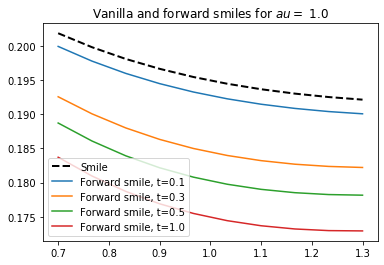

In [60]:
KK = np.linspace(0.7, 1.3, 10)
tt = [0.05, 0.3, 0.5, 1.]
ivs = [heston_Impliedvol(hestonParams,r,tau,1.,K) for K in KK]
plt.figure(figsize=(6,4))
plt.plot(KK, ivs, 'k--', label="Smile", linewidth=2)
for t in tt:
    ivfwds = [hestonImpliedVol_Fwd(K,t,tau,hestonParams) for K in KK]
    plt.plot(KK, ivfwds, label="Forward smile, t=%.1f" %t)
plt.legend(loc="best")
plt.title("Vanilla and forward smiles for $\tau=$ %.1f" %tau)
plt.show()